# Multirotor trajectory optimization with openmdao and FMU

In [1]:
import os.path as pth
import numpy as np
import matplotlib.pyplot as plt
import openmdao.api as om

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


In [2]:
# Loading the different FMUs

from pyfmi import load_fmu

ressources_folder = "../ressources"
speed_model_file_name = "DroneFMU.DroneOptim_Speed.fmu"
torque_model_file_name = "DroneFMU.DroneOptim_Torque.fmu"

speed_file_path = pth.join(ressources_folder, speed_model_file_name)
torque_file_path = pth.join(ressources_folder, torque_model_file_name)

#Load the FMU
speed_model = load_fmu(speed_file_path) # Model
torque_model = load_fmu(torque_file_path) # Model

## Running the model

In [3]:
from trajectory import Model, plot_trajectory

num_points = 50
num_simu_points = 500
final_time = 8.
use_torque = True
model = torque_model

# Initial torque
torque = np.linspace(1., 1., num=num_points) * 2

prob = om.Problem()
prob.model = Model(
                num_points=num_points,
                num_simu_points=num_simu_points,
                final_time=final_time,
                use_torque=use_torque,
                model=model,
)

prob.setup(check=True)

prob["torque"] = torque

prob.run_model()

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Simulation interval    : 0.0 - 7.999999999999999 seconds.
Elapsed simulation time: 0.028612000000002524 seconds.


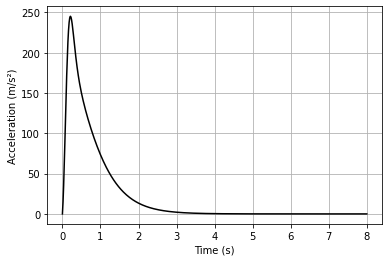

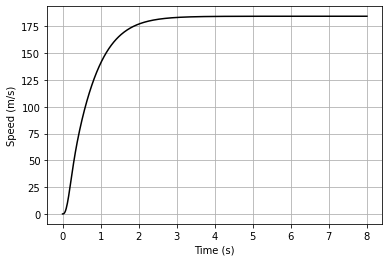

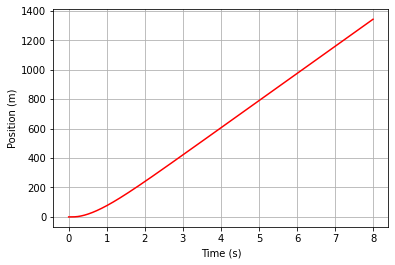

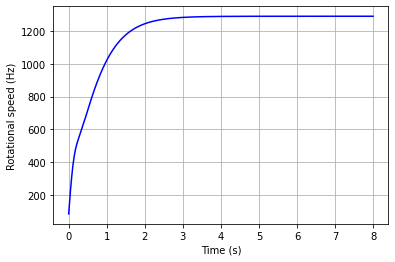

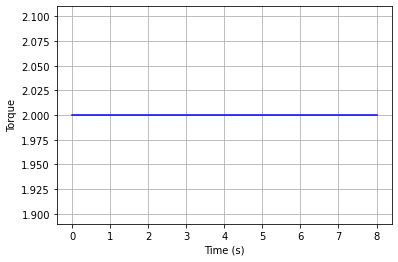

No handles with labels found to put in legend.


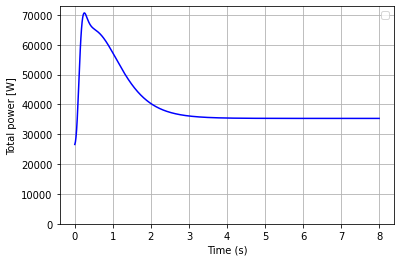

In [4]:
plot_trajectory(prob.model.trajectory.res)

## Run an optimization

In [17]:
from trajectory import Model, plot_trajectory

num_points = 10
num_simu_points = 500
final_time = 5.
use_torque = True
model = torque_model

# Initial torque
torque = np.linspace(0.05, 0.05, num=num_points)

prob = om.Problem()

prob.model = Model(
                num_points=num_points,
                num_simu_points=num_simu_points,
                final_time=final_time,
                use_torque=use_torque,
                model=model,
)

prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['tol'] = 1e-12
prob.driver.options['maxiter'] = 200
prob.model.add_design_var('torque', lower=0.01, upper=0.1)
# prob.model.add_constraint('acc_capacity', lower=0.0)
prob.model.add_constraint('final_speed', lower=0.0, upper=0.0)
prob.model.add_constraint('position', lower=10.)
prob.model.add_objective('total_energy', ref0=100., ref=20000.)
# prob.model.add_objective('total_energy', scaler=1e-3)

prob.setup(check=True)

prob["torque"] = torque

prob.run_driver()

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.024028499999985797 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.02359510000002274 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.019194400000003498 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.019520900000031816 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.020417799999961517 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.020764600000006794 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.020694300000002386 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.021501799999953164 seconds.
Simulatio

True

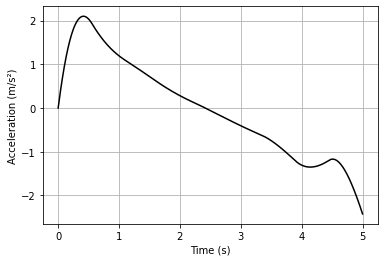

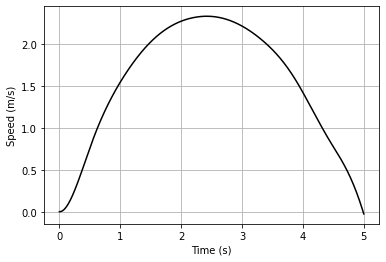

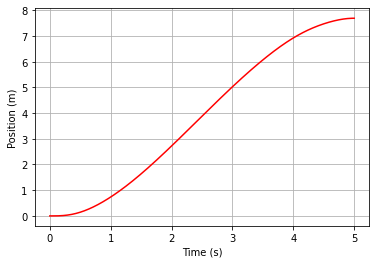

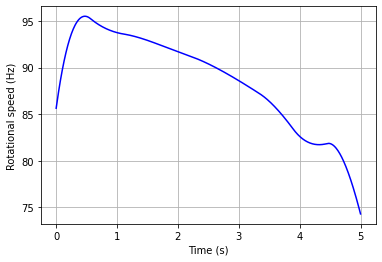

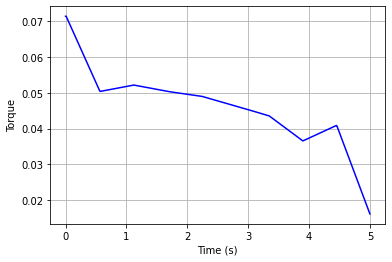

No handles with labels found to put in legend.


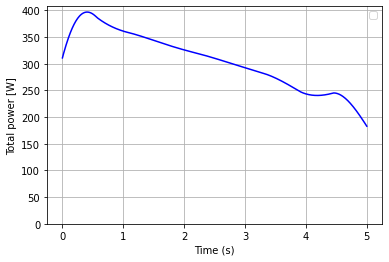

In [18]:
plot_trajectory(prob.model.trajectory.res)